# Fastai 

[Fastai](https://github.com/fastai/fastai) - фреймворк для обучения моделей (NLP, computer vision, collaborative filtering).

Курс по NLP от fast.ai: https://www.fast.ai/2019/07/08/fastai-nlp/ 

## Классификация с RoBERTa

### Источники

Рассмотрим задачу fine-tuning модели RoBERTa для классификации. Будем использовать методы для обработки датасетов и обучения моделей из Fastai и предобученную модель RoBERTa из [fairseq](https://github.com/pytorch/fairseq/blob/master/examples/roberta/README.md). 

https://medium.com/@devkosal/using-roberta-with-fastai-for-nlp-7ed3fed21f6c <br>
https://mlexplained.com/2019/05/13/a-tutorial-to-fine-tuning-bert-with-fast-ai/

[RoBERTa](https://arxiv.org/abs/1907.11692) - модель от Facebook AI на основе BERT. Архитектура такая же, но
* RoBERTa обучалась дольше на большем количестве данных (кроме `BOOKCORPUS`, использовались ещё `CC-NEWS`, `OPENWEBTEXT` (данные с reddit) и `STORIES`)
* В отличие от BERT модель обучалась только на задаче masked language modelling (без обучения предсказанию следующего предложения) с нефиксированным максированием. 
* С настройкой оптимизации (tuning Adam epsilon term)
* С батчами большего размера

In [1]:
!pip install pytorch-transformers

In [26]:
!pip install fastai

In [20]:
from pytorch_transformers import RobertaTokenizer
from fastai.text import *
from fastai.metrics import *

## Параметры

In [21]:
# Creating a config object to store task specific information
class Config(dict):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        for k, v in kwargs.items():
            setattr(self, k, v)
    
    def set(self, key, val):
        self[key] = val
        setattr(self, key, val)
        
config = Config(
    testing=False,
    seed = 2019,
    roberta_model_name='roberta-base', # can also be exchnaged with roberta-large 
    max_lr=1e-5,
    epochs=1,
    use_fp16=False,
    bs=4, 
    max_seq_len=256, 
    num_labels = 2,
    hidden_dropout_prob=.05,
    hidden_size=768, # 1024 for roberta-large
    start_tok = "<s>",
    end_tok = "</s>",
)

## Данные

Используем IMDB датасет.

In [22]:
!wget https://raw.githubusercontent.com/devkosal/fastai_roberta/master/fastai_roberta_imdb/imdb_dataset.csv

--2021-11-24 19:45:20--  https://raw.githubusercontent.com/devkosal/fastai_roberta/master/fastai_roberta_imdb/imdb_dataset.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 66212309 (63M) [text/plain]
Saving to: ‘imdb_dataset.csv.1’

imdb_dataset.csv.1  100%[===================>]  63.14M   139MB/s    in 0.5s    

2021-11-24 19:45:20 (139 MB/s) - ‘imdb_dataset.csv.1’ saved [66212309/66212309]



In [23]:
df = pd.read_csv("imdb_dataset.csv")

In [24]:
if config.testing: df = df[:5000]
print(df.shape)

(50000, 2)


In [19]:
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [25]:
feat_cols = "review"
label_cols = "sentiment"

## Tokenizer

In [26]:
roberta_tok = RobertaTokenizer.from_pretrained("roberta-base")

RoBERTa использует специальные символы начала и конца предложения: \<s\> и \</s\>. <br> Для совместимости с токенайзером из fastai нужно задать обертку над RobertaTokenizer. 

In [27]:
class FastAiRobertaTokenizer(BaseTokenizer):
    """Wrapper around RobertaTokenizer to be compatible with fastai"""
    def __init__(self, tokenizer: RobertaTokenizer, max_seq_len: int=128, **kwargs): 
        self._pretrained_tokenizer = tokenizer
        self.max_seq_len = max_seq_len 
    def __call__(self, *args, **kwargs): 
        return self 
    def tokenizer(self, t:str) -> List[str]: 
        """Adds Roberta bos and eos tokens and limits the maximum sequence length""" 
        return [config.start_tok] + self._pretrained_tokenizer.tokenize(t)[:self.max_seq_len - 2] + [config.end_tok]

In [28]:
# create fastai tokenizer for roberta
roberta_tok = RobertaTokenizer.from_pretrained("roberta-base")

fastai_tokenizer = Tokenizer(tok_func=FastAiRobertaTokenizer(roberta_tok, max_seq_len=config.max_seq_len), 
                             pre_rules=[], post_rules=[])

In [29]:
FastAiRobertaTokenizer(roberta_tok).tokenizer('the movie was great')

['<s>', 'Ġthe', 'Ġmovie', 'Ġwas', 'Ġgreat', '</s>']

Создадим словарь.

In [30]:
# create fastai vocabulary for roberta
path = Path()
roberta_tok.save_vocabulary(path)

with open('vocab.json', 'r') as f:
    roberta_vocab_dict = json.load(f)
    
fastai_roberta_vocab = Vocab(list(roberta_vocab_dict.keys()))

In [31]:
# Setting up pre-processors
class RobertaTokenizeProcessor(TokenizeProcessor):
    def __init__(self, tokenizer):
         super().__init__(tokenizer=tokenizer, include_bos=False, include_eos=False)

class RobertaNumericalizeProcessor(NumericalizeProcessor):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, vocab=fastai_roberta_vocab, **kwargs)


def get_roberta_processor(tokenizer:Tokenizer=None, vocab:Vocab=None):
    """
    Constructing preprocessors for Roberta
    We remove sos and eos tokens since we add that ourselves in the tokenizer.
    We also use a custom vocabulary to match the numericalization with the original Roberta model.
    """
    return [RobertaTokenizeProcessor(tokenizer=tokenizer), NumericalizeProcessor(vocab=vocab)]

## DataBunch

Класс DataBunch для предварительной обработки и подготовки данных для модели Roberta. Создает батчи с учетом длины последовательностей, добавляет padding.

![fastai](fastai.jpg)

In [32]:
# Creating a Roberta specific DataBunch class
class RobertaDataBunch(TextDataBunch):
    "Create a `TextDataBunch` suitable for training Roberta"
    @classmethod
    def create(cls, train_ds, valid_ds, test_ds=None, path:PathOrStr='.', bs:int=64, val_bs:int=None, pad_idx=1,
               pad_first=True, device:torch.device=None, no_check:bool=False, backwards:bool=False, 
               dl_tfms:Optional[Collection[Callable]]=None, **dl_kwargs) -> DataBunch:
        "Function that transform the `datasets` in a `DataBunch` for classification. Passes `**dl_kwargs` on to `DataLoader()`"
        datasets = cls._init_ds(train_ds, valid_ds, test_ds)
        val_bs = ifnone(val_bs, bs)
        collate_fn = partial(pad_collate, pad_idx=pad_idx, pad_first=pad_first, backwards=backwards)
        train_sampler = SortishSampler(datasets[0].x, key=lambda t: len(datasets[0][t][0].data), bs=bs)
        train_dl = DataLoader(datasets[0], batch_size=bs, sampler=train_sampler, drop_last=True, **dl_kwargs)
        dataloaders = [train_dl]
        for ds in datasets[1:]:
            lengths = [len(t) for t in ds.x.items]
            sampler = SortSampler(ds.x, key=lengths.__getitem__)
            dataloaders.append(DataLoader(ds, batch_size=val_bs, sampler=sampler, **dl_kwargs))
        return cls(*dataloaders, path=path, device=device, dl_tfms=dl_tfms, collate_fn=collate_fn, no_check=no_check)

In [33]:
class RobertaTextList(TextList):
    _bunch = RobertaDataBunch
    _label_cls = TextList

In [34]:
# loading the tokenizer and vocab processors
processor = get_roberta_processor(tokenizer=fastai_tokenizer, vocab=fastai_roberta_vocab)

# creating our databunch 
data = RobertaTextList.from_df(df, ".", cols=feat_cols, processor=processor) \
    .split_by_rand_pct(seed=config.seed) \
    .label_from_df(cols=label_cols,label_cls=CategoryList) \
    .databunch(bs=config.bs, pad_first=False, pad_idx=0)

/usr/local/lib/python3.7/dist-packages/fastai/core.py:302: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(a, dtype=dtype, **kwargs)


In [35]:
data

RobertaDataBunch;

Train: LabelList (40000 items)
x: RobertaTextList
<s> ĠA Ġwonderful Ġlittle Ġproduction . Ġ< br Ġ/ >< br Ġ/> The Ġfilming Ġtechnique Ġis Ġvery Ġun assuming - Ġvery Ġold - time - BBC Ġfashion Ġand Ġgives Ġa Ġcomforting , Ġand Ġsometimes Ġdiscomfort ing , Ġsense Ġof Ġrealism Ġto Ġthe Ġentire Ġpiece . Ġ< br Ġ/ >< br Ġ/> The Ġactors Ġare Ġextremely Ġwell Ġchosen - ĠMichael ĠSheen Ġnot Ġonly Ġ" has Ġgot Ġall Ġthe Ġpol ari " Ġbut Ġhe Ġhas Ġall Ġthe Ġvoices Ġdown Ġpat Ġtoo ! ĠYou Ġcan Ġtruly Ġsee Ġthe Ġseamless Ġediting Ġguided Ġby Ġthe Ġreferences Ġto ĠWilliams ' Ġdiary Ġentries , Ġnot Ġonly Ġis Ġit Ġwell Ġworth Ġthe Ġwatching Ġbut Ġit Ġis Ġa Ġterrific ly Ġwritten Ġand Ġperformed Ġpiece . ĠA Ġmaster ful Ġproduction Ġabout Ġone Ġof Ġthe Ġgreat Ġmaster 's Ġof Ġcomedy Ġand Ġhis Ġlife . Ġ< br Ġ/ >< br Ġ/> The Ġrealism Ġreally Ġcomes Ġhome Ġwith Ġthe Ġlittle Ġthings : Ġthe Ġfantasy Ġof Ġthe Ġguard Ġwhich , Ġrather Ġthan Ġuse Ġthe Ġtraditional Ġ' dream ' Ġtechniques Ġremains Ġso

# Model

In [36]:
import torch
import torch.nn as nn
from pytorch_transformers import RobertaModel

# defining our model architecture 
class CustomRobertaModel(nn.Module):
    def __init__(self,num_labels=2):
        super(CustomRobertaModel,self).__init__()
        self.num_labels = num_labels
        self.roberta = RobertaModel.from_pretrained(config.roberta_model_name)
        self.dropout = nn.Dropout(config.hidden_dropout_prob)
        self.classifier = nn.Linear(config.hidden_size, num_labels) # defining final output layer
        
    def forward(self, input_ids, token_type_ids=None, attention_mask=None, labels=None):
        _ , pooled_output = self.roberta(input_ids, token_type_ids, attention_mask) # 
        logits = self.classifier(pooled_output)        
        return logits

In [37]:
roberta_model = CustomRobertaModel(num_labels=config.num_labels)

learn = Learner(data, roberta_model, metrics=[accuracy])

100%|██████████| 501200538/501200538 [00:14<00:00, 34724621.24B/s]


In [ ]:
learn.model.roberta.train() # setting roberta to train as it is in eval mode by default
learn.fit_one_cycle(config.epochs, max_lr=config.max_lr)

epoch,train_loss,valid_loss,accuracy,time


KeyboardInterrupt: ignored

In [ ]:
config.max_lr

1e-05

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


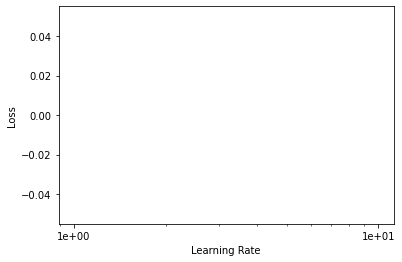

In [ ]:
# find an appropriate lr
learn.lr_find()
learn.recorder.plot()

# Predictions

In [ ]:
def get_preds_as_nparray(ds_type) -> np.ndarray:
    learn.model.roberta.eval()
    preds = learn.get_preds(ds_type)[0].detach().cpu().numpy()
    sampler = [i for i in data.dl(ds_type).sampler]
    reverse_sampler = np.argsort(sampler)
    ordered_preds = preds[reverse_sampler, :]
    pred_values = np.argmax(ordered_preds, axis=1)
    return ordered_preds, pred_values

In [ ]:
preds, pred_values = get_preds_as_nparray(DatasetType.Valid)

In [ ]:
# accuracy on valid
(pred_values == data.valid_ds.y.items).mean()

0.9428

# SuperGLUE Task CB

[SuperGLUE](https://super.gluebenchmark.com) benchmark представляет задания для тестирования качества моделей.

1. Broadcoverage Diagnostics (AX-b)
2. CommitmentBank (CB)
3. Choice of Plausible Alternatives (COPA)
4. Multi-Sentence Reading Comprehension (MultiRC)
5. Recognizing Textual Entailment (RTE)
6. Words in Context (WiC)
7. The Winograd Schema Challenge (WC)
8. BoolQ
9. Reading Comprehension with Commonsense Reasoning (ReCoRD)
10. Winogender Schema Diagnostics (AX-g)

**CB Task**. CommitmentBank - датасет для задачи textual entailment. Дана предпосылка (premise), нужно определить, является ли предложенная гипотеза (hypothesis) для предпосылки следствием (entailment), противоречит ли гипотеза предпосылке (contradiction), или между ними нет связи (neutral). https://github.com/mcdm/CommitmentBank


### Источник
https://medium.com/analytics-vidhya/using-roberta-with-fastai-for-superglue-task-cb-c362961be957

In [38]:
from fastai.text import *
from fastai.metrics import *
#from pytorch_transformers import RobertaTokenizer

In [39]:

# Creating a config object to store task specific information
class Config(dict):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        for k, v in kwargs.items():
            setattr(self, k, v)
    
    def set(self, key, val):
        self[key] = val
        setattr(self, key, val)
        
config = Config(
    task = "CB",
    testing=False,
    seed = 2019,
    roberta_model_name='roberta-base', # can also be exchanged with roberta-large 
    max_lr=1e-5,
    epochs=10,
    use_fp16=False,
    bs=4, 
    max_seq_len=256, 
    num_labels = 3,
    hidden_dropout_prob=.05,
    hidden_size=768, # 1024 for roberta-large
    start_tok = "<s>",
    end_tok = "</s>",
    mark_fields=True,
)

## CommitmentBank

Скрипт для скачивания данных:
 https://github.com/nyu-mll/jiant/blob/2d0b19f504ffc6fc489d8a397aa4e29dd22decc6/scripts/download_superglue_data.py

In [40]:
!wget  https://raw.githubusercontent.com/nyu-mll/jiant/2d0b19f504ffc6fc489d8a397aa4e29dd22decc6/scripts/download_superglue_data.py

!python /content/download_superglue_data.py --data_dir /content/data --tasks CB

--2021-11-24 19:50:00--  https://raw.githubusercontent.com/nyu-mll/jiant/2d0b19f504ffc6fc489d8a397aa4e29dd22decc6/scripts/download_superglue_data.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4077 (4.0K) [text/plain]
Saving to: ‘download_superglue_data.py.1’

download_superglue_ 100%[===================>]   3.98K  --.-KB/s    in 0s      

2021-11-24 19:50:00 (54.1 MB/s) - ‘download_superglue_data.py.1’ saved [4077/4077]

	Completed! Downloaded CB data to directory /content/data


In [41]:
path = Path("/content")
data_path = path/"data"

In [42]:
train = pd.read_json(data_path/config.task/"train.jsonl",lines=True)
val = pd.read_json(data_path/config.task/"val.jsonl",lines=True)
test = pd.read_json(data_path/config.task/"test.jsonl",lines=True)

In [43]:
train[:10]

,premise,hypothesis,label,idx
0,It was a complex language. Not written down bu...,the language was peeled down,entailment,0
1,"It is part of their religion, a religion I do ...",no women are allowed to take part in this ritual,entailment,1
2,The Paris to Rouen railway was being extended ...,Gustave was shepherded into creative retreat a...,entailment,2
3,Part of it was to be compulsorily purchased. Y...,Gustave was driven to creative retreat in Croi...,entailment,3
4,"Some of them, like for instance the farm in Co...",buying places is a hobby,entailment,4
5,"Look, my dear, I'm not in my dotage yet, and I...",the only form of comfort he has are his compla...,entailment,5
6,Then the silence in the Zoo became complete. W...,Woil was afraid,entailment,6
7,"But, of course, that just wasn't possible. Her...",marriage to Jonathan would have been a ghastly...,entailment,7
8,Like now. The Community in Knockglen would def...,the girl had a point,entailment,8
9,"``They have to be crushed, Bobkins!'' So sayin...",behind the house was a vast garden,entailment,9


In [44]:
# drop the unnecessary idx column
for df in (train,val):
    if "idx" in df.columns: df.drop("idx",axis=1,inplace=True)

In [45]:
if config.testing:
    train = train[:100]
    val = val[:100]
    
print(train.shape)
print(val.shape)
print(test.shape)

(250, 3)
(56, 3)
(250, 3)


In [46]:
train.label.value_counts()


contradiction    119
entailment       115
neutral           16
Name: label, dtype: int64

In [47]:
feat_cols = ["premise","hypothesis"]
label_cols = "label"

### Tokenizer

Специальные символы начала и конца последовательности для разделения нескольких предложений: <br>
`<s>` after taking a quick nap, the sheep crossed the street `<s>` `<s>` the sheep took a nap `<s>`

In [48]:
class FastAiRobertaTokenizer(BaseTokenizer):
    """Wrapper around RobertaTokenizer to be compatible with fastai"""
    def __init__(self, tokenizer: RobertaTokenizer, max_seq_len: int=128, **kwargs): 
        self._pretrained_tokenizer = tokenizer
        self.max_seq_len = max_seq_len 
    def __call__(self, *args, **kwargs): 
        return self 
    def tokenizer(self, t:str) -> List[str]: 
        """Adds Roberta bos and eos tokens and limits the maximum sequence length""" 
        if config.mark_fields:
            sub = 2 # subtraction in totoal seq_length to be made due to adding spcl tokens
            assert "xxfld" in t
            t = t.replace("xxfld 1","") # remove the xxfld 1 special token from fastai
            # converting fastai field sep token to Roberta
            t = re.split(r'xxfld \d+', t) 
            res = []
            for i in range(len(t)-1): # loop over the number of additional fields and the Roberta sep
                res += self._pretrained_tokenizer.tokenize(t[i]) + [config.end_tok, config.end_tok]
                sub += 2 # increase our subtractions since we added more spcl tokens
            res += self._pretrained_tokenizer.tokenize(t[-1]) # add the last sequence
            return [config.start_tok] + res[:self.max_seq_len - sub] + [config.end_tok] 
        
        res = self._pretrained_tokenizer.tokenize(t)
        return [config.start_tok] + res[:self.max_seq_len - sub] + [config.end_tok]

In [49]:
#  create fastai tokenizer for roberta
roberta_tok = RobertaTokenizer.from_pretrained("roberta-base")

fastai_tokenizer = Tokenizer(tok_func=FastAiRobertaTokenizer(roberta_tok, max_seq_len=config.max_seq_len), 
                             pre_rules=[], post_rules=[])

Аналогично загружается словарь RoBERTa, создается DataBunch.

In [50]:
# create fastai vocabulary for roberta
roberta_tok.save_vocabulary(path)

with open('vocab.json', 'r') as f:
    roberta_vocab_dict = json.load(f)
    
fastai_roberta_vocab = Vocab(list(roberta_vocab_dict.keys()))

In [51]:
# Setting up pre-processors
class RobertaTokenizeProcessor(TokenizeProcessor):
    def __init__(self, tokenizer):
         super().__init__(tokenizer=tokenizer, include_bos=False, include_eos=False, mark_fields=config.mark_fields)

class RobertaNumericalizeProcessor(NumericalizeProcessor):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, vocab=fastai_roberta_vocab, **kwargs)


def get_roberta_processor(tokenizer:Tokenizer=None, vocab:Vocab=None):
    """
    Constructing preprocessors for Roberta
    We remove sos and eos tokens since we add that ourselves in the tokenizer.
    We also use a custom vocabulary to match the numericalization with the original Roberta model.
    """
    return [RobertaTokenizeProcessor(tokenizer=tokenizer), NumericalizeProcessor(vocab=vocab)]

In [52]:
# Creating a Roberta specific DataBunch class
class RobertaDataBunch(TextDataBunch):
    "Create a `TextDataBunch` suitable for training Roberta"
    @classmethod
    def create(cls, train_ds, valid_ds, test_ds=None, path:PathOrStr='.', bs:int=64, val_bs:int=None, pad_idx=1,
               pad_first=True, device:torch.device=None, no_check:bool=False, backwards:bool=False, 
               dl_tfms:Optional[Collection[Callable]]=None, **dl_kwargs) -> DataBunch:
        "Function that transform the `datasets` in a `DataBunch` for classification. Passes `**dl_kwargs` on to `DataLoader()`"
        datasets = cls._init_ds(train_ds, valid_ds, test_ds)
        val_bs = ifnone(val_bs, bs)
        collate_fn = partial(pad_collate, pad_idx=pad_idx, pad_first=pad_first, backwards=backwards)
        train_sampler = SortishSampler(datasets[0].x, key=lambda t: len(datasets[0][t][0].data), bs=bs)
        train_dl = DataLoader(datasets[0], batch_size=bs, sampler=train_sampler, drop_last=True, **dl_kwargs)
        dataloaders = [train_dl]
        for ds in datasets[1:]:
            lengths = [len(t) for t in ds.x.items]
            sampler = SortSampler(ds.x, key=lengths.__getitem__)
            dataloaders.append(DataLoader(ds, batch_size=val_bs, sampler=sampler, **dl_kwargs))
        return cls(*dataloaders, path=path, device=device, dl_tfms=dl_tfms, collate_fn=collate_fn, no_check=no_check)

In [53]:
# loading the tokenizer and vocab processors
processor = get_roberta_processor(tokenizer=fastai_tokenizer, vocab=fastai_roberta_vocab)

# creating our databunch 
data = ItemLists(".", RobertaTextList.from_df(train, ".", cols=feat_cols, processor=processor),
                      RobertaTextList.from_df(val, ".", cols=feat_cols, processor=processor)
                ) \
       .label_from_df(cols=label_cols, label_cls=CategoryList) \
       .add_test(RobertaTextList.from_df(test, ".", cols=feat_cols, processor=processor)) \
       .databunch(bs=4,pad_first=False)

/usr/local/lib/python3.7/dist-packages/fastai/core.py:302: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(a, dtype=dtype, **kwargs)


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


### Model

Здесь используется класс RobertaForSequenceClassification - трансформер Roberta с линейным слоем для классификации последовательностей.

In [54]:
import torch
import torch.nn as nn
from pytorch_transformers import RobertaForSequenceClassification

# defining our model architecture 
class RobertaForSequenceClassificationModel(nn.Module):
    def __init__(self,num_labels=config.num_labels):
        super(RobertaForSequenceClassificationModel,self).__init__()
        self.num_labels = num_labels
        self.roberta = RobertaForSequenceClassification.from_pretrained(config.roberta_model_name,num_labels= self.num_labels)

    def forward(self, input_ids, token_type_ids=None, attention_mask=None, labels=None):
        outputs = self.roberta(input_ids, token_type_ids, attention_mask)
        logits = outputs[0] 
        return logits

In [55]:
roberta_model = RobertaForSequenceClassificationModel() 

learn = Learner(data, roberta_model, metrics=[accuracy])

In [56]:
learn.model.roberta.train() # setting roberta to train as it is in eval mode by default
learn.fit_one_cycle(config.epochs, max_lr=config.max_lr)

epoch,train_loss,valid_loss,accuracy,time
0,1.104129,1.059355,0.500000,00:17
1,0.990282,0.834426,0.660714,00:16
2,0.789593,0.760779,0.732143,00:18
3,0.613320,0.567723,0.803571,00:17
4,0.363814,0.317545,0.875000,00:16
5,0.222652,0.343143,0.892857,00:17
6,0.133399,0.331561,0.892857,00:17
7,0.082485,0.170705,0.910714,00:17
8,0.056632,0.172528,0.928571,00:17
9,0.042053,0.172500,0.946429,00:17


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


### Predictions

In [57]:
def get_preds_as_nparray(ds_type) -> np.ndarray:
    learn.model.roberta.eval()
    preds = learn.get_preds(ds_type)[0].detach().cpu().numpy()
    sampler = [i for i in data.dl(ds_type).sampler]
    reverse_sampler = np.argsort(sampler)
    ordered_preds = preds[reverse_sampler, :]
    pred_values = np.argmax(ordered_preds, axis=1)
    return ordered_preds, pred_values

In [58]:
# val preds
preds, pred_values = get_preds_as_nparray(DatasetType.Valid)

In [59]:
# accuracy for valid 
(pred_values == data.valid_ds.y.items).mean()

0.9464285714285714

In [60]:
# test preds
_, test_pred_values = get_preds_as_nparray(DatasetType.Test)

In [61]:
# accuracy for test
(test_pred_values == data.test_ds.y.items).mean()

0.468